In [4]:
# здесь только импорт
import requests, json
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import math

from bs4 import BeautifulSoup
import string
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
import copy
from joblib import Parallel, delayed, wrap_non_picklable_objects, parallel_backend
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook
from fake_useragent import UserAgent
import re

In [3]:
# посылаем запросы через хост ТОРа
import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [6]:
# если вдруг захочется проверить свой IP
def checkIP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = BeautifulSoup(ip, 'html.parser')
    print(soup.find('body').text)

checkIP()

Current IP Address: 54.38.52.137


In [7]:
# функция парсинга объектов постранично
def parsing_new(i):
    try:
        response = requests.get('https://www.domofond.ru/prodazha-kvartiry-samara-c2415?Page=' + str(i), headers={'User-Agent': UserAgent().chrome})
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        string_soup = str(soup)

        indexes = [m.start() for m in re.finditer('itemUrl', string_soup)]
        for j in range(len(indexes)):
            index_finish = string.find(string_soup[(indexes[j]+11):], ',')
            hrefs = string_soup[(indexes[j]+11):(indexes[j]+10+index_finish)]
            clean_hrefs = 'https://www.domofond.ru/' + hrefs
            our_links.append(clean_hrefs)
    except:
        null

In [8]:
# функция парсинга для одной ссылки
def parse_single_flat(i):
    try:
        # забираем стоимость квадратного метра

        response = requests.get(our_links[i])
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        soup_str = str(soup)
        index_start = string.find(soup_str, '"Цена за м²","value"')
        index_finish = string.find(soup_str[index_start+30:], '₽')
        sq_m_price_str = soup_str[(index_start+30):(index_start+30+index_finish)]
        sq_m_price_str = sq_m_price_str.replace(' ', '')
        try:
            sq_m_price = float(sq_m_price_str)
        except:
            sq_m_price = None

        # забираем координаты объекта (широта и долгота)
        try:
            str_start = string.find(soup_str, 'longitude') + 11
            str_finish = string.find(soup_str, 'latitude') - 2
            coord_1 = float(soup_str[str_start:str_finish])
        except:
            coord_1 = None

        try:
            str_start = string.find(soup_str, 'latitude') + 10
            str_finish = string.find(soup_str, 'latitude') + 18
            coord_2 = float(soup_str[str_start:str_finish])
        except:
            coord_2 = None

        dataset_flats.loc[i, 'lng'] = coord_1
        dataset_flats.loc[i, 'lat'] = coord_2
        dataset_flats.loc[i, 'sq_meter_price'] = sq_m_price
    except:
        dataset_flats.loc[i, 'lng'] = None
        dataset_flats.loc[i, 'lat'] = None
        dataset_flats.loc[i, 'sq_meter_price'] = None

In [10]:
# собираем ссылки на квартиры

our_links = list()

with parallel_backend('threading', n_jobs = 8):
    Parallel()(delayed(parsing_new)(m) for m in tqdm_notebook(range(348)))

In [11]:
# заносим список в датасет
dataset_flats = pd.DataFrame(our_links, columns=['link'])

In [12]:
# ходим по ссылкам на квартиры и собираем геопозицию и цену квадратного метра

with parallel_backend('threading', n_jobs = 8):
    Parallel()(delayed(parse_single_flat)(m) for m in tqdm_notebook(range(len(our_links))))

In [13]:
# визуалзируем данные
dataset_flats.loc[dataset_flats['lng'] > 53, 'lng'] = None
dataset_flats.loc[dataset_flats['lng'] < 49.5, 'lng'] = None
x_data = dataset_flats.dropna()['lng']
y_data = dataset_flats.dropna()['lat']
z_data = dataset_flats.dropna()['sq_meter_price'].sort_values(ascending = True)

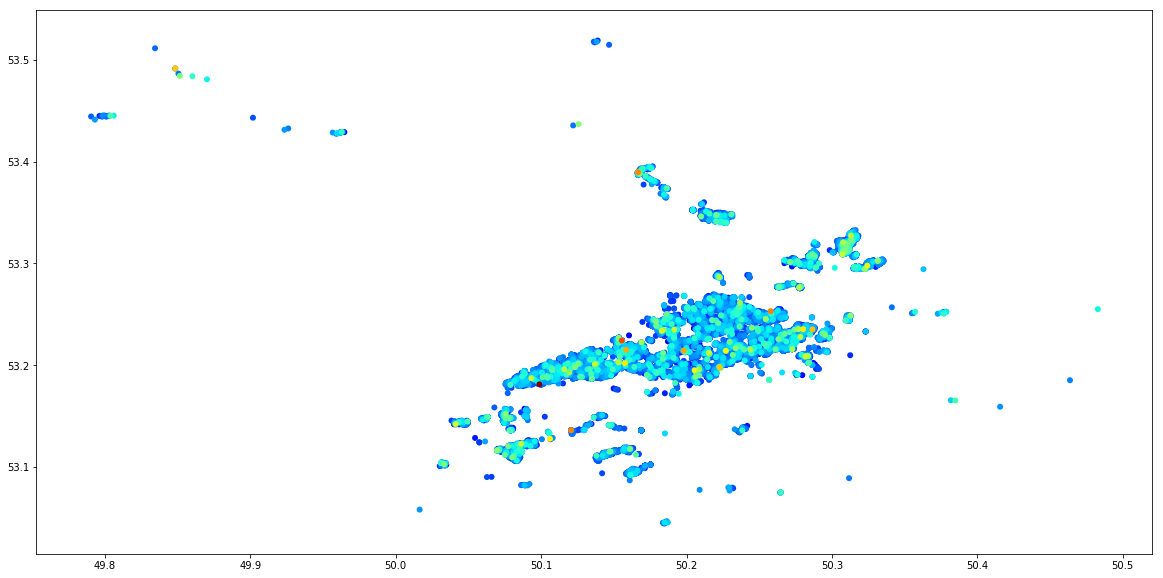

In [14]:
# посмотрим на плоскости, размер кружочка соответствует цене
plt.figure(figsize=(20,10))
plt.scatter(x_data, y_data, marker = 'o',
                   c =  z_data,
                   cmap=cm.jet,
                   linewidths = 0)

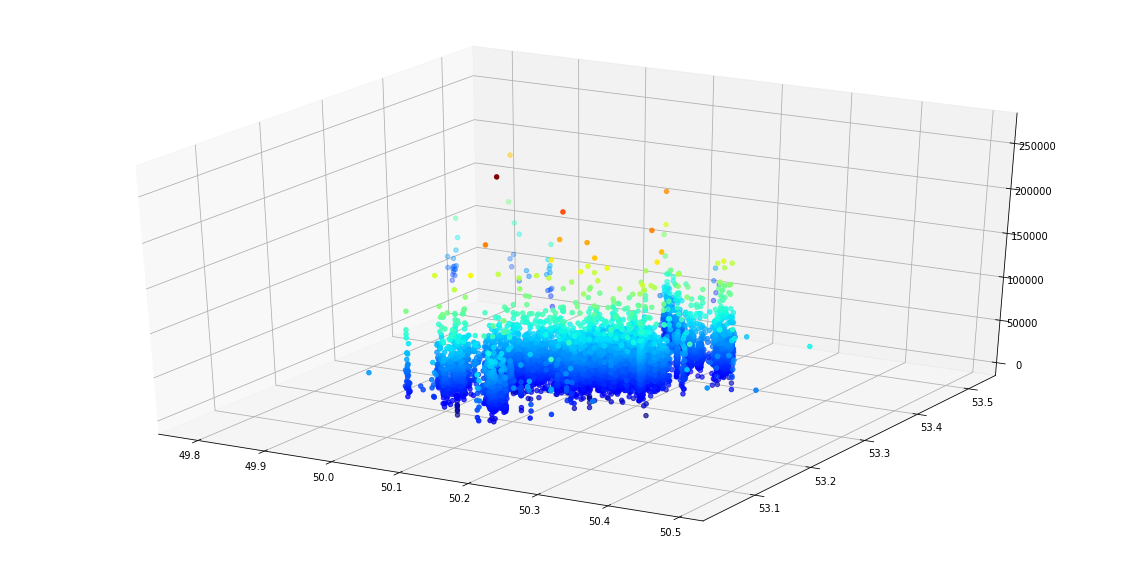

In [15]:
# попробуем посмотреть 3D
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter(x_data, y_data, z_data, c=z_data, cmap=cm.jet, marker='o')

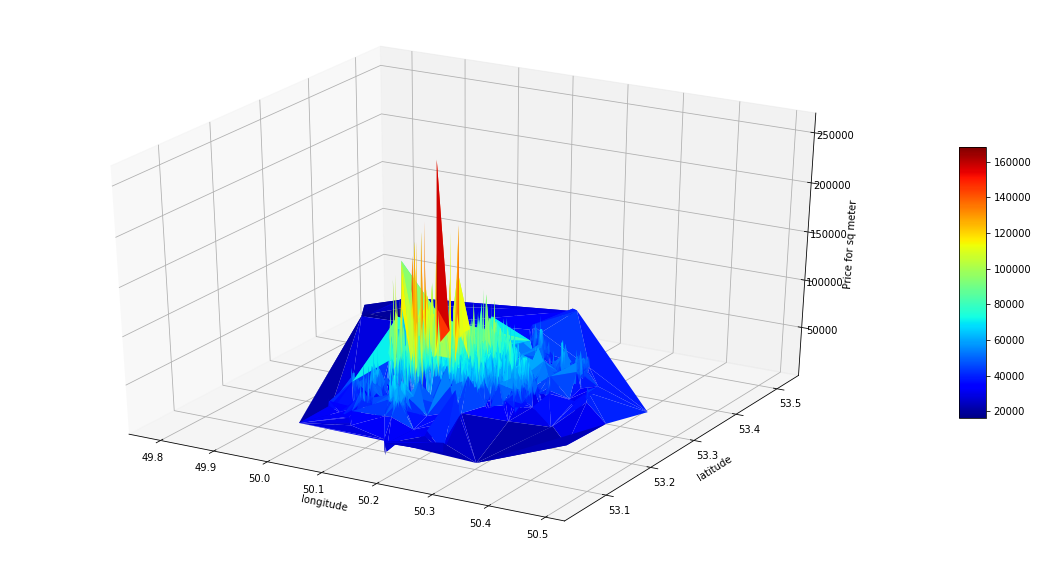

In [16]:
# построим поверхность
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('Price for sq meter')
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

df = pd.DataFrame({'x': x_data, 'y': y_data, 'z': z_data})
surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=10)    
#ax.view_init(90, 90)
plt.show()

In [17]:
# посмотрим на квартиры только в Самаре
samara_only = copy.deepcopy(dataset_flats)
samara_only.loc[samara_only['lng'] < 49.6, 'lng'] = None
x_data_s = samara_only.dropna()['lng']
y_data_s = samara_only.dropna()['lat']
z_data_s = samara_only.dropna()['sq_meter_price'].sort_values()

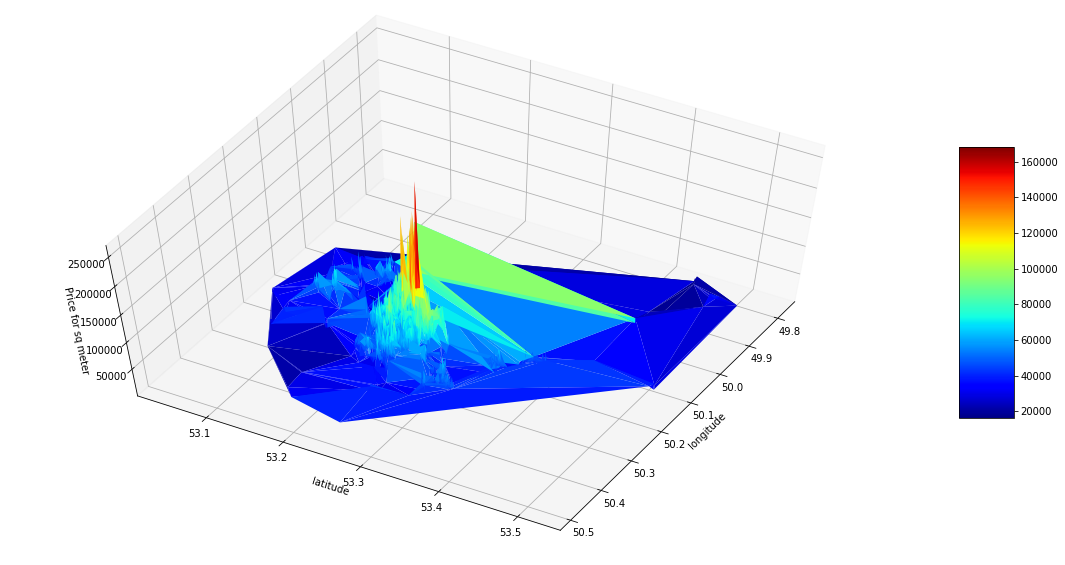

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('Price for sq meter')
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

df = pd.DataFrame({'x': x_data_s, 'y': y_data_s, 'z': z_data_s})
surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)    
ax.view_init(60, 30)
plt.show()

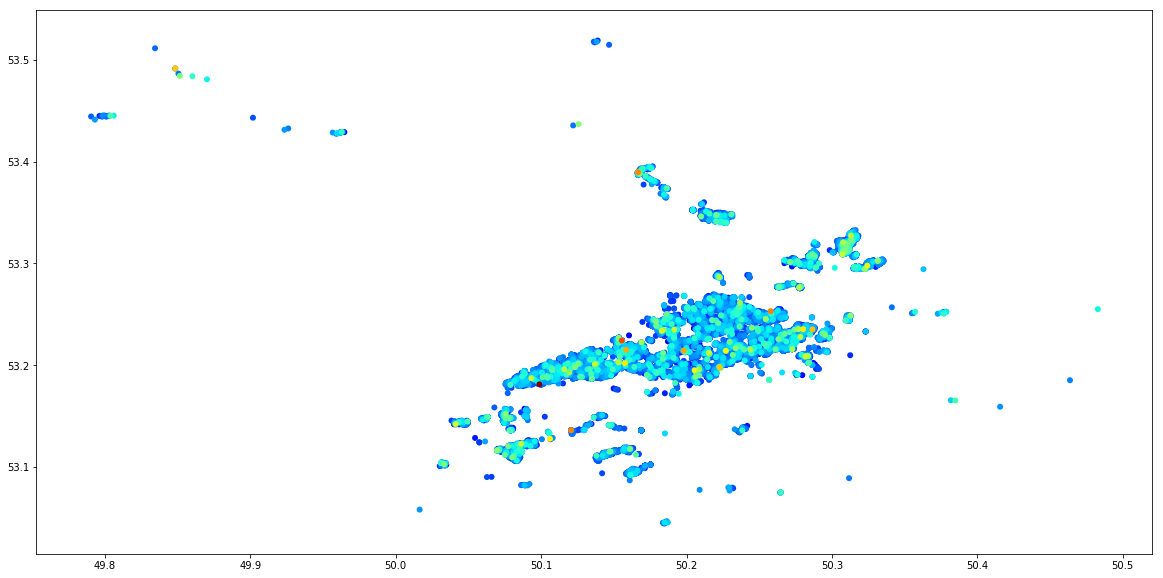

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(x_data_s, y_data_s, marker = 'o',
                   c =  z_data_s,
                   cmap=cm.jet,
                   linewidths = 0)

In [6]:
samara_only_dropped = pd.read_excel('dropped_table.xlsx')

In [20]:
# Элементы машинного обучения

In [9]:
# Линейная регрессия

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X = samara_only_dropped[['lng', 'lat']].values
y = samara_only_dropped[['sq_meter_price']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

df_lr = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': y_pred.ravel()})

In [10]:
df_lr.head(15)

,Actual,Predicted
0,75000,58744.687711
1,79167,65170.331243
2,49750,55036.487366
3,58568,58305.179441
4,39375,67712.858779
5,55102,55640.966070
6,55556,54530.588408
7,44811,54372.925134
8,24127,70362.029063
9,62914,59934.535028


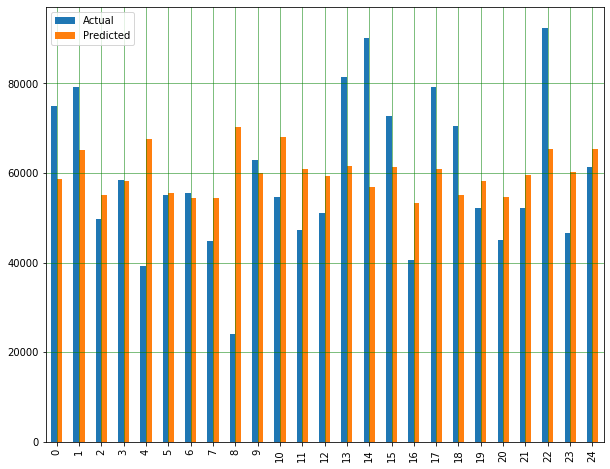

In [11]:
df_lr.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [12]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 14307.47039429358
Mean Squared Error: 389356508.2830691
Root Mean Squared Error: 19732.11869726789


In [13]:
# Случайный лес

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [14]:
predictions = rf.predict(X_test)

In [15]:
df_rf = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': predictions.ravel()})

In [16]:
df_rf.head(15)

,Actual,Predicted
0,75000,68051.419662
1,79167,79671.000071
2,49750,49691.585760
3,58568,52892.424557
4,39375,46624.065091
5,55102,58047.600528
6,55556,53069.078132
7,44811,59844.748661
8,24127,28425.021648
9,62914,59116.246090


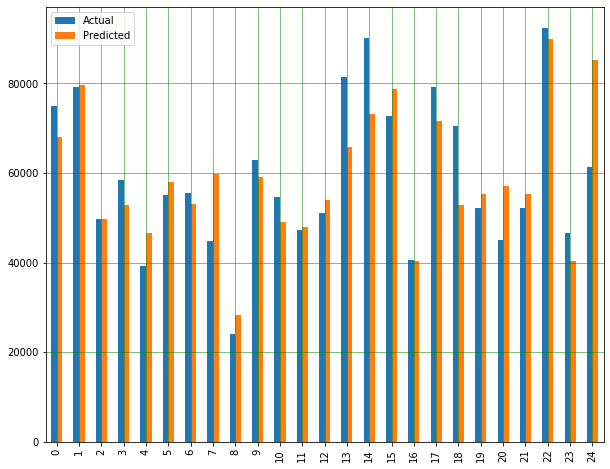

In [17]:
df_rf.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [18]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 8037.473623074559
Mean Squared Error: 135134069.87038913
Root Mean Squared Error: 11624.718055522428


In [34]:
from sklearn import tree
import dtreeviz.trees

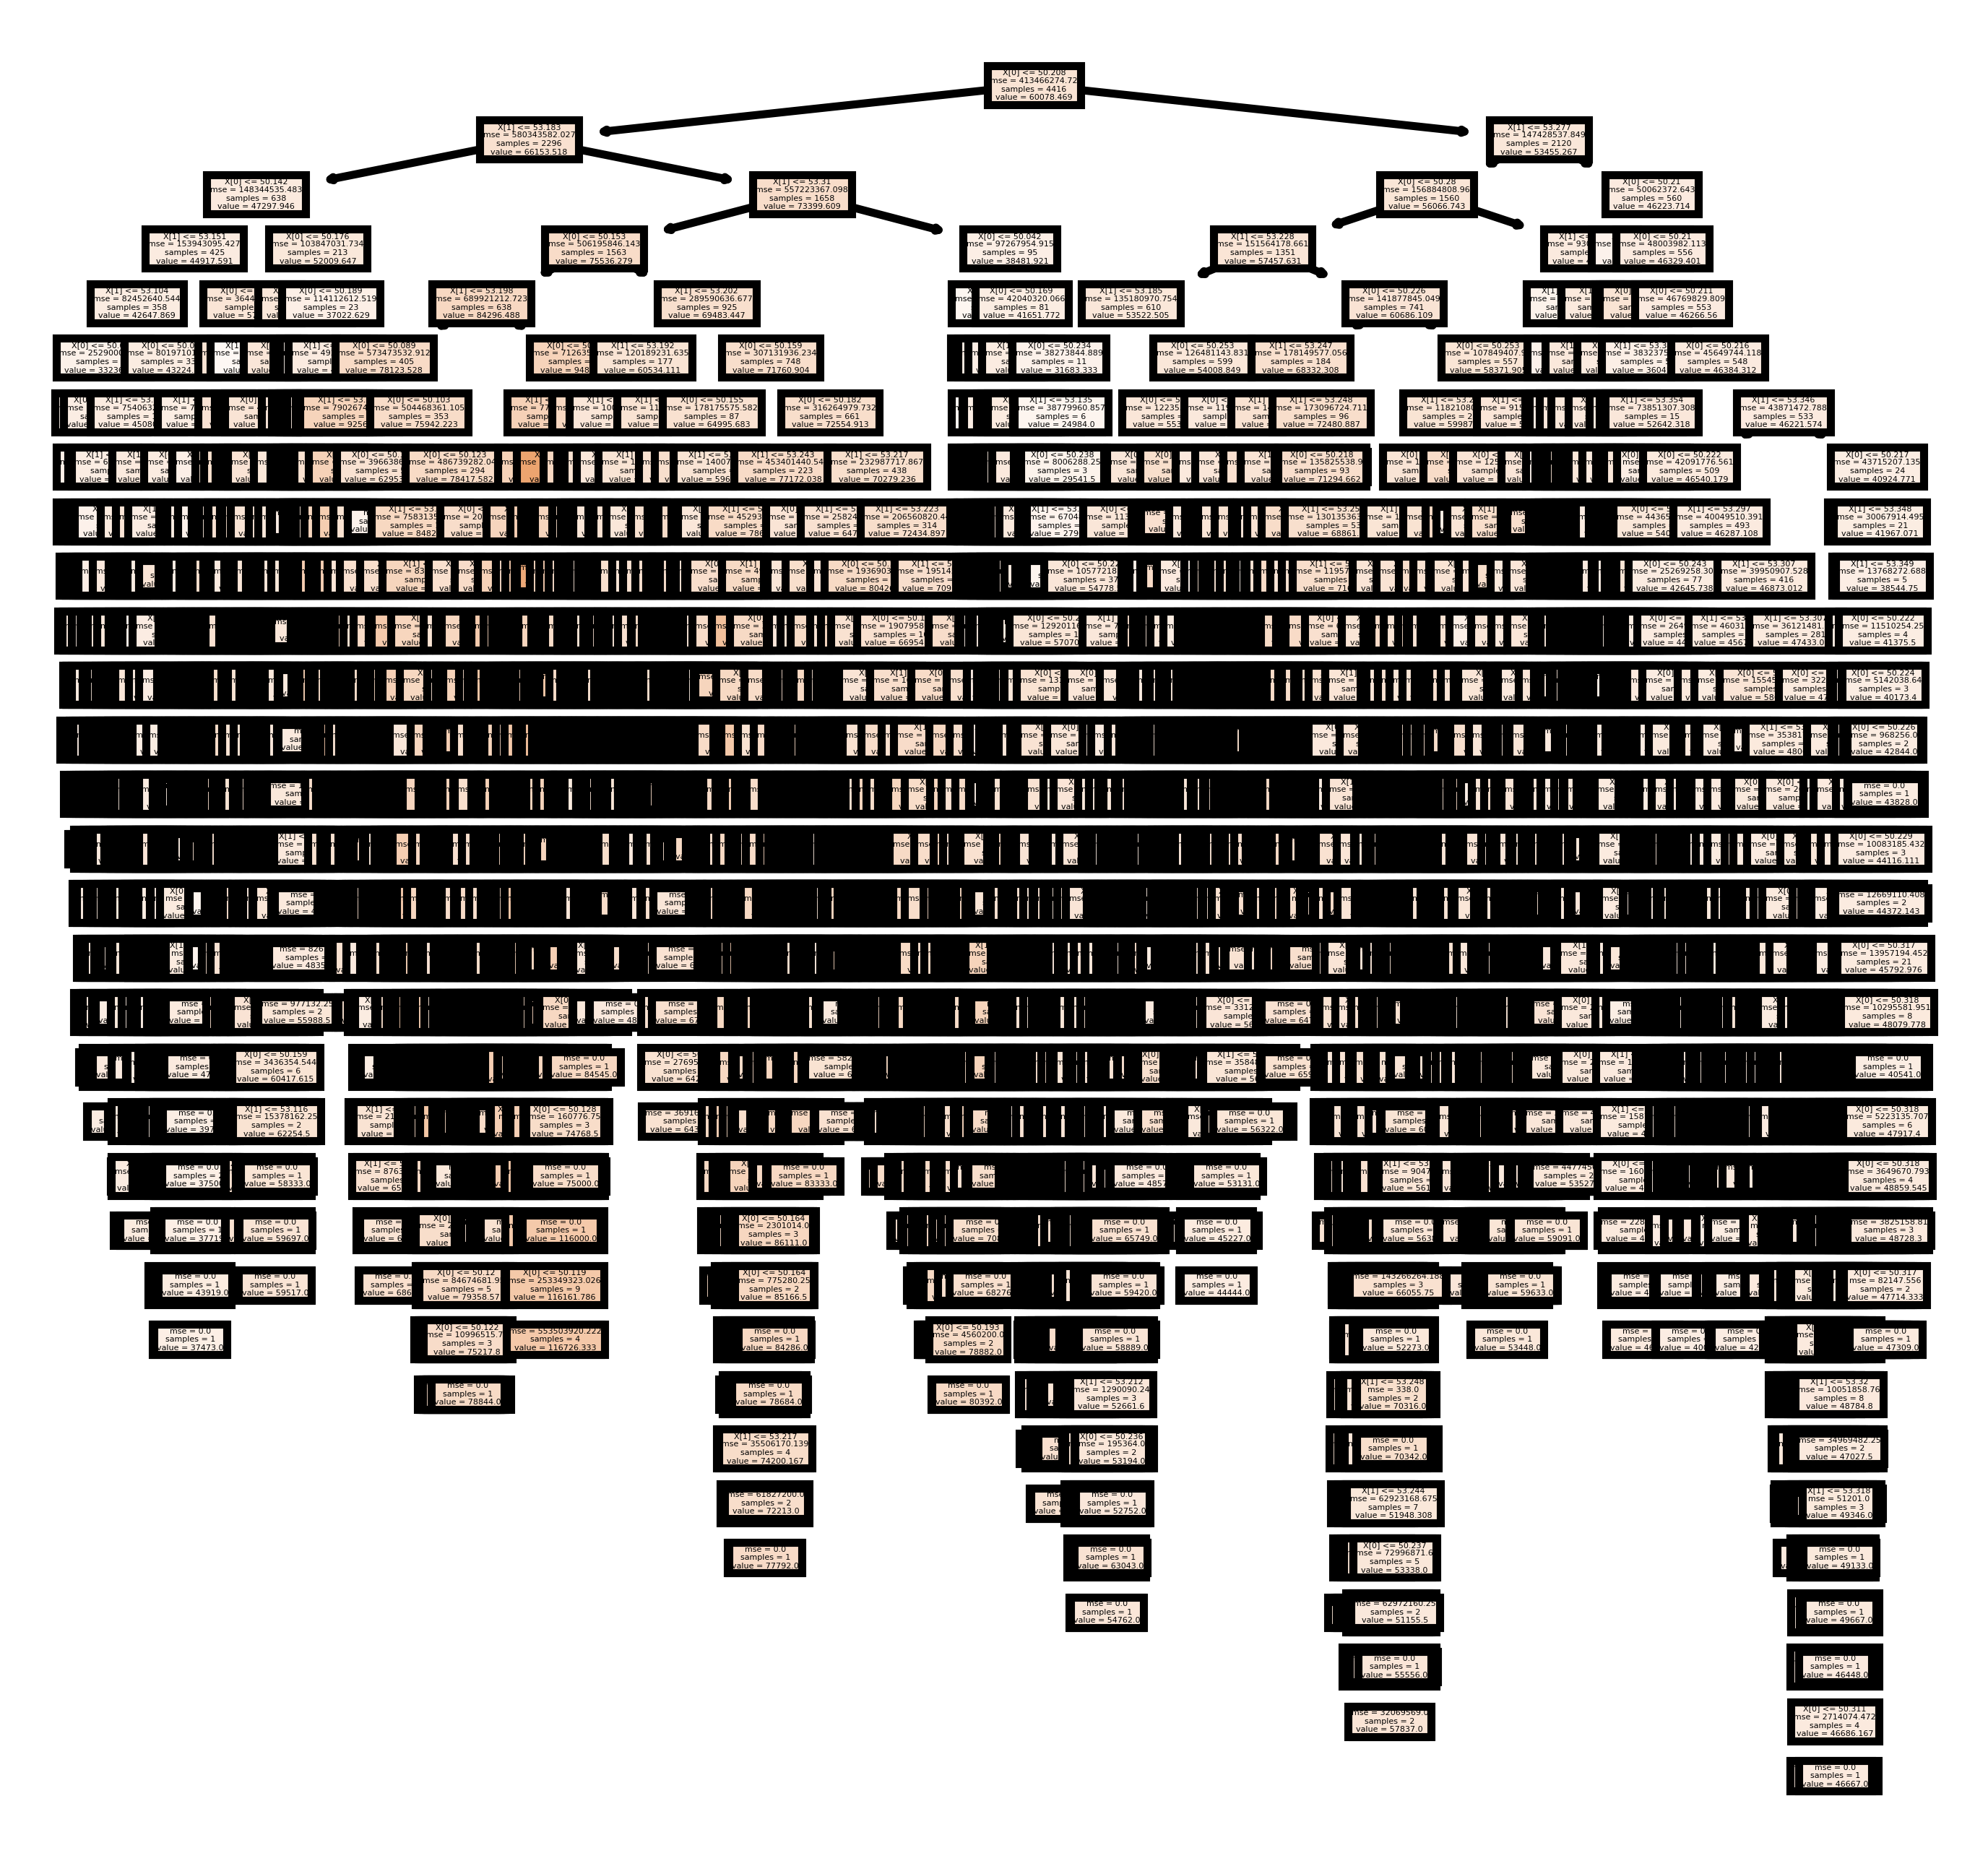

In [47]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0], filled = True)
fig.savefig('rf_individualtree.png')

In [59]:
all_predictions = regressor.predict(X)
pred_table = pd.DataFrame({'Actual': y.ravel(), 'Predicted': all_predictions.ravel()})
pred_table.to_excel('pred_table.xlsx')

In [60]:
samara_only_dropped.to_excel('dropped_table.xlsx')

In [61]:
samara_only_dropped = samara_only_dropped.reset_index(drop = True)
samara_only_dropped['Predicted'] = pred_table['Predicted']

In [62]:
samara_only_dropped['Discount'] = (samara_only_dropped['Predicted'] - samara_only_dropped['sq_meter_price']) / samara_only_dropped['Predicted']

In [63]:
list_of_k = list()
for j in range(101):
    k = 0
    for i in range(len(samara_only_dropped)):
        if (samara_only_dropped.loc[i, 'Discount'] < (float(j)/100)) & (samara_only_dropped.loc[i, 'Discount'] > (-float(j)/100)):
            k = k+1
    list_of_k.append(100 * float(k) / len(samara_only_dropped))

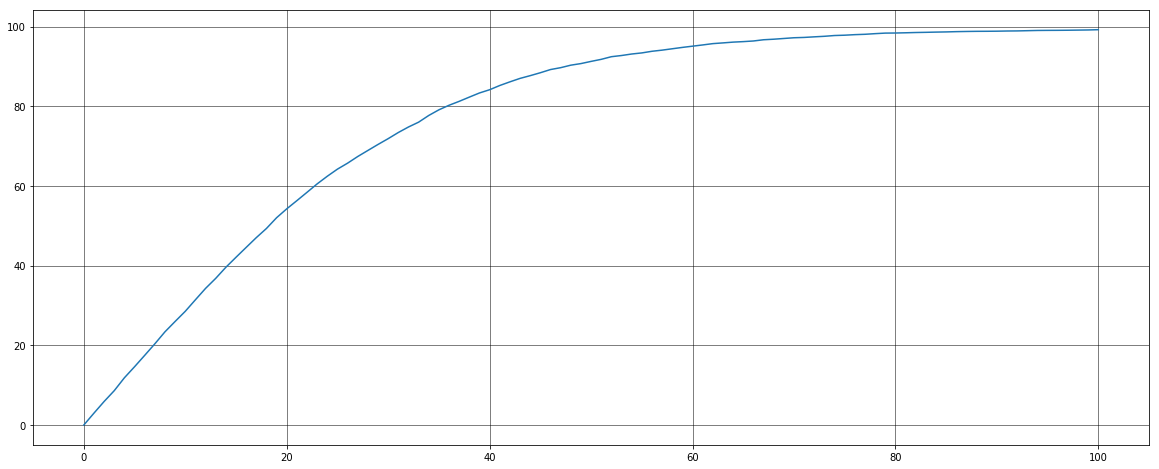

In [64]:
plt.figure(figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.plot(list_of_k)

In [65]:
list_of_k

[0.0,
 2.9845626072041167,
 5.900514579759863,
 8.622069754145226,
 11.858204688393368,
 14.625500285877644,
 17.48427672955975,
 20.37735849056604,
 23.39622641509434,
 25.99199542595769,
 28.542024013722127,
 31.435105774728417,
 34.29388221841052,
 36.80960548885077,
 39.58833619210978,
 42.104059462550026,
 44.57404230989137,
 47.03259005145797,
 49.33104631217839,
 52.02973127501429,
 54.259576901086334,
 56.31789594053745,
 58.41052029731275,
 60.52601486563751,
 62.44711263579188,
 64.23098913664951,
 65.72898799313894,
 67.39851343624929,
 68.91938250428817,
 70.42881646655232,
 71.88107489994283,
 73.42481417953115,
 74.8084619782733,
 76.02058319039452,
 77.70154373927959,
 79.11949685534591,
 80.26300743281875,
 81.2464265294454,
 82.30989136649514,
 83.35048599199543,
 84.16237850200115,
 85.22584333905088,
 86.14065180102916,
 87.00971983990851,
 87.69582618639222,
 88.42767295597484,
 89.22813036020584,
 89.6969696969697,
 90.32590051457976,
 90.72612921669526,
 91.275014